In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import nltk
import os
import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/bbc-news-data.csv', sep='\t')
df = df.drop(columns=['filename'])
df

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
## lematization
lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df.title = df.title.apply(lambda x: lem(x))
    df.content = df.content.apply(lambda x: lem(x))

In [5]:
# removing stopword
st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df.title = df.title.apply(lambda x: stopword(x))
    df.content = df.content.apply(lambda x: lem(x))

In [6]:
# removing functuation
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df_new.title = df_new.title.apply(lambda x: cleaner(x))
    df_new.content = df_new.content.apply(lambda x: lem(x))

In [7]:
# One-hot encoding

category = pd.get_dummies(df.category)
df_encoding = pd.concat([df, category], axis=1)
df_encoding = df_encoding.drop(columns='category')
df_encoding

,title,content,business,entertainment,politics,sport,tech
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,1,0,0,0,0
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,1,0,0,0,0
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,1,0,0,0,0
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,1,0,0,0,0
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,1,0,0,0,0
...,...,...,...,...,...,...,...
2220,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,0,0,0,0,1
2221,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,0,0,0,0,1
2222,Be careful how you code,A new European directive could put software w...,0,0,0,0,1
2223,US cyber security chief resigns,The man making sure US computer networks are ...,0,0,0,0,1


In [8]:
# Change dataframe values

bbcNews = df_encoding['title'].values + '' + df_encoding['content'].values
label = df_encoding[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [9]:
# Split data

bbcNews_train, bbcNews_test, label_train, label_test = train_test_split(bbcNews, label, test_size=0.2, shuffle=True)

In [10]:
# Apply tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token='x', filters=';<=>@%&()|}*+!"#$^_,-:[\]`{./~ ')
tokenizer.fit_on_texts(bbcNews_train) 
tokenizer.fit_on_texts(bbcNews_test)
 
sequence_train = tokenizer.texts_to_sequences(bbcNews_train)
sequence_test = tokenizer.texts_to_sequences(bbcNews_test)
 
pad_train = pad_sequences(sequence_train) 
pad_test = pad_sequences(sequence_test)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [12]:
model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy',)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 435,973
Trainable params: 435,973
Non-trainable params: 0
_________________________________________________________________


In [14]:
# callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93 and logs.get('val_accuracy')>0.93):
      self.model.stop_training = True
      print("\nThe accuracy has reached more than 93%!")
callbacks = myCallback()

In [15]:
number_epochs = 40
history = model.fit(pad_train, label_train, epochs=number_epochs, 
                    validation_data=(pad_test, label_test), verbose=2,
                    callbacks=[callbacks])

Epoch 1/40
56/56 - 339s - loss: 1.5988 - accuracy: 0.2393 - val_loss: 1.5161 - val_accuracy: 0.2899
Epoch 2/40
56/56 - 331s - loss: 1.2621 - accuracy: 0.4416 - val_loss: 1.0264 - val_accuracy: 0.5258
Epoch 3/40
56/56 - 336s - loss: 0.7317 - accuracy: 0.6966 - val_loss: 0.5944 - val_accuracy: 0.7416
Epoch 4/40
56/56 - 333s - loss: 0.6896 - accuracy: 0.7455 - val_loss: 1.0094 - val_accuracy: 0.6135
Epoch 5/40
56/56 - 335s - loss: 0.5656 - accuracy: 0.8090 - val_loss: 0.7211 - val_accuracy: 0.7258
Epoch 6/40
56/56 - 333s - loss: 0.1566 - accuracy: 0.9556 - val_loss: 0.5381 - val_accuracy: 0.8292
Epoch 7/40
56/56 - 332s - loss: 0.1222 - accuracy: 0.9657 - val_loss: 0.6122 - val_accuracy: 0.8157
Epoch 8/40
56/56 - 333s - loss: 0.0309 - accuracy: 0.9949 - val_loss: 0.6910 - val_accuracy: 0.8292
Epoch 9/40
56/56 - 333s - loss: 0.0361 - accuracy: 0.9910 - val_loss: 0.7174 - val_accuracy: 0.8157
Epoch 10/40
56/56 - 334s - loss: 0.0108 - accuracy: 0.9989 - val_loss: 0.6201 - val_accuracy: 0.8517

In [16]:
score = model.evaluate(pad_train, label_train)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

56/56 [==============================] - 71s 1s/step - loss: 6.2365e-06 - accuracy: 1.0000
Loss: 0.0000
Accuracy: 1.0000


In [17]:
score = model.evaluate(pad_test, label_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

14/14 [==============================] - 14s 976ms/step - loss: 0.5596 - accuracy: 0.9303
Loss: 0.5596
Accuracy: 0.9303


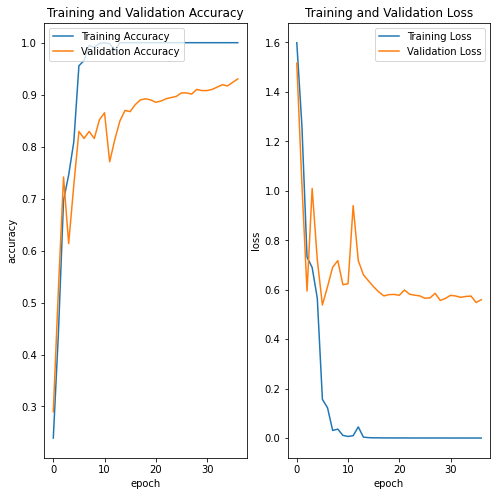

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(number_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Rokhmat Febrianto

Bergabung sejak 16 Mar 2021

Kabupaten Sidoarjo, Jawa Timur 